<a href="https://colab.research.google.com/github/AlexeyEvzrezov/DS_projects/blob/master/time_series_taxi_orders_prediction/time_series_taxi_orders_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование количества заказов такси

В данной работе на основе исторических данных мы построим модели для прогнозирования количества заказов такси в аэропорт на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.  
Для оценки качества будем использовать метрику RMSE, ее значение должно быть не хуже 48.

## Содержание
- [Описание данных](#0)
1. [Загрузка и подготовка данных](#1)    
2. [Анализ данных](#2)    
3. [Обучение и настройка моделей](#3)
4. [Тестирование](#4)
- [Выводы](#5)

<a id="0"></a> 
## Описание данных
Признаки
- datetime - время заказа
- num_orders - количество заказов (целевой признак)

<a id="1"></a> 
## Загрузка и подготовка данных

In [11]:
# импорт библиотек
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

from sklearn.model_selection import GridSearchCV, cross_val_score, \
                                    PredefinedSplit, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.compose import ColumnTransformer

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

Загрузим данные и посмотрим на них.

In [12]:
taxi_df = pd.read_csv('/content/drive/My Drive/Datasets/taxi.csv',
                      parse_dates=['datetime'],
                      index_col='datetime')                 

In [13]:
taxi_df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [14]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [15]:
taxi_df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Данные в порядке.  
Отсортируем по дате, сделаем ресемплирование по одному часу и посмотрим, как это выглядит на графике.

(4416, 1)

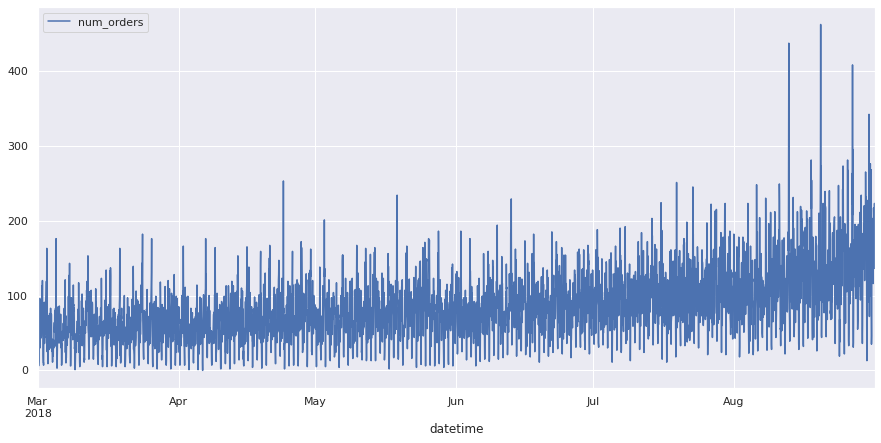

In [16]:
df = taxi_df.sort_index().resample('1H').sum()
df.plot(figsize=(15, 7));
df.shape

<a id="2"></a> 
## 2. Анализ данных

Применим скользящее среднее, чтобы сгладить ряд и лучше увидеть тренд.  
Построим анимированный график и посмотрим на поведение кривой при изменении размера окна.

In [17]:
def win_move(df, win_min, win_max, step):
    out = df.copy()
    out['win_size'] = 1
    out_list = [out]

    for i, win_size in enumerate(range(win_min, win_max, step)):
        rolled = df.rolling(win_size).mean()
        out_list.append(rolled)
        rolled['win_size'] = win_size
        
    return pd.concat(out_list)

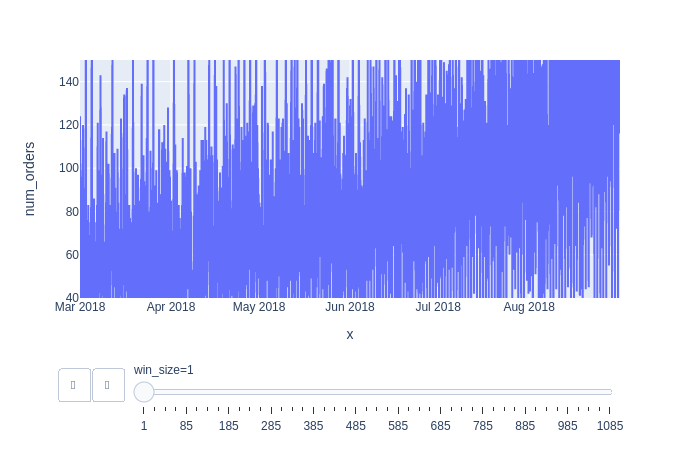

In [18]:
_ = win_move(df, 10, 1100, 25).dropna()

fig = px.line(_, x=_.index, y='num_orders', animation_frame='win_size', 
              animation_group='num_orders', range_y=[40, 150], width=1000)
fig.show('png')

Мы имеем выраженный возрастающий тренд.  
Посмотрим, присутствует ли сезонная составляющая.

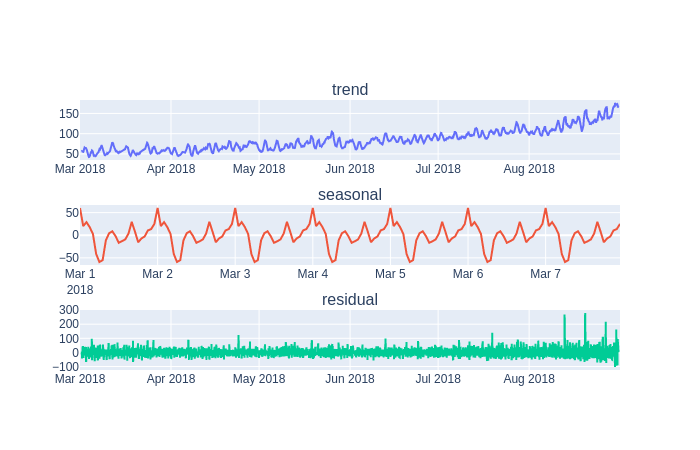

In [19]:
decomp = seasonal_decompose(df)

fig = make_subplots(rows=3, cols=1, 
                    subplot_titles=['trend', 'seasonal', 'residual'])
cols = [decomp.trend, decomp.seasonal[:24*7], decomp.resid]
for i, col in enumerate(cols):
    fig.append_trace(go.Scatter(
        x=col.index,
        y=col.num_orders,  
        showlegend=False
    ), row=i+1, col=1)

fig.update_layout(height=600, width=600)
fig.show('png')

Очевидно наличие суточной сезонности.  

Таким образом, мы наблюдаем стохастический нестационарный процесс с возрастающим трендом и суточной сезонностью, шумы в целом невелики и стабильны, при этом отметим их нарастание ближе к концу исследуемого периода.

<a id="3"></a> 
## 3. Обучение моделей

Реализуем функцию для создания дополнительных признаков и разделения данных на обучающую и тестовую выборки.  
Что касается отстающих значений, то предусмотрим возможность брать их с произвольным шагом, при этом оставляя справа и слева соседние значения. Учтем, что в этом случае шаг не может быть равен единице.

In [20]:
def make_features_split(df, max_lag, lag_step, rolling_size, weekend_days=[5, 6]):
    '''
    Добавляет новые признаки:
    - час, день, день недели, является ли день выходным;
    - лаги;
    - скользящее среднее с суточным смещением.
    Разделяет данные на обучающую и тестовую выборки.
    '''
    out_df = df.copy()
    out_df.columns = ['y']
    out_df['hour'] = df.index.hour
    out_df['dayofweek'] = df.index.dayofweek
    
    out_df['lag_1'] = out_df.y.shift()
    for lag in range(lag_step, max_lag+1, lag_step):
        out_df[f'lag_{lag-1}'] = out_df.y.shift(lag-1)
        out_df[f'lag_{lag}'] = out_df.y.shift(lag)
        out_df[f'lag_{lag+1}'] = out_df.y.shift(lag+1)
        

    out_df['rolling_mean'] = out_df.y.shift(24).rolling(rolling_size).mean()

    out_df = out_df.dropna()

    X_train, X_test, y_train, y_test = train_test_split(out_df.drop('y', axis=1),
                                                        out_df.y,
                                                        shuffle=False,
                                                        test_size=.1)

    return X_train, X_test, y_train, y_test

Для подбора гиперпараметров по сетке реализуем следующую стратегию кросс-валидации - предопределим единственную проверку в соотношении 9:1 в рамках обучающей выборки.

In [21]:
def cv(X_train):
    train_len = int(X_train.shape[0] * .9)
    test_len = X_train.shape[0] - train_len
    # индексы со значенимями -1 останутся в трейне
    train_indices = np.full((train_len,), -1, dtype=int)
    # индексы со значенимями 0 пойдут в тест
    test_indices = np.full((test_len,), 0, dtype=int)
    test_fold = np.append(train_indices, test_indices)

    return PredefinedSplit(test_fold)

Теперь подберем параметры, определяющие состав новых признаков.  
Сделаем это с использованием линейной регрессии в качестве базовой модели, а после подбора перейдем к рассмотрению других моделей на лучших полученных параметрах.

In [22]:
def rmse_valid(model, X_train, y_train):
    rmse = cross_val_score(model, 
                           X_train, 
                           y_train, 
                           cv=cv(X_train), 
                           scoring='neg_root_mean_squared_error') 
    return rmse

lr = LinearRegression()
best_rmse_neg = -100
for i in range(3, 15):
    for rolling_size in range(1, 10):
        for lag_step in [2, 12, 24, ]:
            X_train, X_test, y_train, y_test = make_features_split(
                df, max_lag=lag_step*i, lag_step=lag_step, rolling_size=rolling_size)
            rmse_neg = rmse_valid(lr, X_train, y_train)
            if best_rmse_neg < rmse_neg:
                best_rmse_neg = rmse_neg
                best_params = dict(lag_step=lag_step,
                                   lag_step_period=i,
                                   rolling_size=rolling_size
                                   )
                print('RMSE:', *-best_rmse_neg, best_params)

RMSE: 35.774585098744964 {'lag_step': 2, 'lag_step_period': 3, 'rolling_size': 1}
RMSE: 34.86532602605182 {'lag_step': 12, 'lag_step_period': 3, 'rolling_size': 1}
RMSE: 30.565668125387184 {'lag_step': 24, 'lag_step_period': 3, 'rolling_size': 1}
RMSE: 30.557225803764165 {'lag_step': 24, 'lag_step_period': 3, 'rolling_size': 3}
RMSE: 30.525820247726568 {'lag_step': 24, 'lag_step_period': 3, 'rolling_size': 4}
RMSE: 30.02272718240871 {'lag_step': 24, 'lag_step_period': 4, 'rolling_size': 1}
RMSE: 30.022727182408705 {'lag_step': 24, 'lag_step_period': 4, 'rolling_size': 2}
RMSE: 30.01954369120802 {'lag_step': 24, 'lag_step_period': 4, 'rolling_size': 3}
RMSE: 29.993718319357132 {'lag_step': 24, 'lag_step_period': 4, 'rolling_size': 4}
RMSE: 29.986961244055657 {'lag_step': 24, 'lag_step_period': 4, 'rolling_size': 7}
RMSE: 29.981896052935955 {'lag_step': 24, 'lag_step_period': 4, 'rolling_size': 8}
RMSE: 28.958108309639712 {'lag_step': 24, 'lag_step_period': 7, 'rolling_size': 1}
RMSE: 28

Для референса оценим RMSE на полученной валидационной выборке при наивном прогнозе, предполагающем, что модельное значение в следующем периоде будет равно значению в текущем периоде. 

In [23]:
train_len = int(X_train.shape[0] * .9)
naive_pred = y_train[train_len:].shift()
naive_pred.iloc[0] = y_train.iloc[train_len-1]

print('RMSE прогноза предыдущим значением на валидации:')
print(mean_squared_error(y_train[train_len:], naive_pred) ** .5)

RMSE прогноза предыдущим значением на валидации:
48.11633885924189


Подготовим выборки с учетом полученных параметров и зафиксируем стратегию кросс-валидации.

In [24]:
X_train, X_test, y_train, y_test = make_features_split(df, 24*14, 24, 5)

pscv = cv(X_train)

Рассмотрим другие линейные модели и градиентный бустинг.

In [25]:
pipe = Pipeline(steps=[('model', LinearRegression())
                      ])

In [26]:
params = [{'model': [LinearRegression()]
           }, 
          {'model': [Lasso(random_state=0)],
           'model__alpha': np.logspace(-3, 2, 6)
           },
          {'model': [Ridge(random_state=0)],
           'model__alpha': np.logspace(-3, 2, 6)
           },
          {'model': [LGBMRegressor(verbose=0, random_state=0, n_estimators=100)],
           'model__num_leaves': [2, 16, 31],
           'model__n_estimators': [20, 100, 600],
           'model__learning_rate': [0.02, 0.1]
           }
          ]

grid = GridSearchCV(pipe, 
                    param_grid=params, 
                    scoring='neg_root_mean_squared_error', 
                    cv=pscv, verbose=True)

In [27]:
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)

Fitting 1 folds for each of 31 candidates, totalling 31 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-28.685208444205408
{'model': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=False), 'model__alpha': 1.0}


[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:   17.6s finished


Легко убедиться, что линейные модели показывают наилучшие результаты.  
При этом регрессия с L1 регуляризацией позволила нам пусть и незначительно, но улучшить качество.  

Посмотрим, что нам удастся получить на тестовой выборке.

<a id="4"></a> 
## 4. Тестирование 

Для начала на тестовой выборке реализуем такой же наивный прогноз, как и перед обучением. 

In [28]:
naive_pred_test = y_test.shift()
naive_pred_test.iloc[0] = y_train.iloc[-1]

print('RMSE прогноза предыдущим значением на валидации:')
print(mean_squared_error(y_test, naive_pred_test) ** .5)

RMSE прогноза предыдущим значением на валидации:
59.28993648695747


И наконец, оценим RMSE лучшей модели.

In [29]:
pred = grid.predict(X_test)
print(mean_squared_error(y_test, pred) ** .5)

34.35049530284028


Обратим внимание, что относительно наивного прогноза результаты практически идентичны полученным на валидации.

Сравним прогнозные и реальные значения на графике.

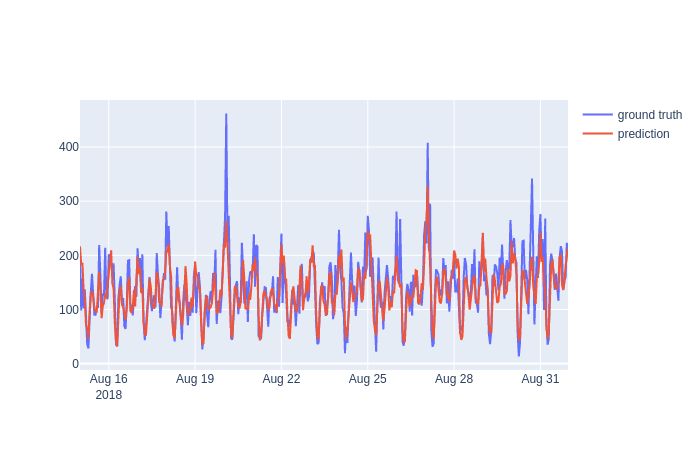

In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, name='ground truth'))
fig.add_trace(go.Scatter(x=y_test.index, y=pred, name='prediction'))
fig.show('png')

Видно, что прогнозные значения лежат в более узком диапазоне, главным образом отставая от реальных на верхних границах.

<a id="5"></a> 
## Выводы

В рамках данной работы мы проанализировали исторические данные о количестве заказов такси в аэропорт и построили модели для предсказания этого количества на час вперед.

Мы произвели почасовое ресемплирование увидели стохастический нестационарный процесс с возрастающим трендом (почти трехратное увеличение в рамках наблюдаемого периода) и выраженной суточной сезонностью.

Для целей моделирования были сгенерированы новые признаки - календарные, отстающие значения и скользящее среднее.
Был произведен подбор параметров, определяющих состав новых признаков, с использованием линейной регрессии в качестве базовой модели.
Для валидации мы оставили 10% последних объектов обучающей выборки, тем самым использовав такое же соотношение, как при финальном тестировании.

Призведя поиск по сетке мы увидели, что линейные модели показывают наилучшие результаты. Лучшей моделью оказалась LASSO.

На тестовой выборке мы получили RMSE на уровне 34.35, что ощутимо лучше заданного максимально допустимого значения (48). Этот результат является сопоставимым с полученным нами на валидации относительно наивного прогноза.
Отметим еще раз, что прогнозные значения лежат в более узком диапазоне, главным образом отставая от реальных на верхних границах. Это стоит учитывать при дальнейшем усовершенствовании модели и работе с ней.